<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/SV_unet_lonlat_features_15s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [4]:
data_train = pd.read_csv('./data/SV_train.csv')
data_validation = pd.read_csv('./data/SV_validation.csv')
data_test = pd.read_csv('./data/SV_test.csv')

In [5]:
resolution = 15

data_train_new = change_resolution(data_train, resolution)
data_validation_new = change_resolution(data_validation, resolution)
data_test_new = change_resolution(data_test, resolution)

data_train_new = standardize_data(data_train_new)
data_validation_new = standardize_data(data_validation_new)
data_test_new = standardize_data(data_test_new)

data_train_new.head()

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_46_SV_T4,2008-12-06 16:06:45,-77.267390,-11.775845,0.0,0,12.387955,-43.649088,2.283183,0.674779,0.676298,0.723581,-0.690240
3,P1108_46_SV_T4,2008-12-06 16:07:00,-77.267043,-11.776942,0.0,0,8.522006,-51.264040,2.293314,0.593278,0.464731,0.625732,-0.780038
4,P1108_46_SV_T4,2008-12-06 16:07:15,-77.268240,-11.776373,0.0,0,9.666699,133.105568,2.258366,0.635552,0.527375,-0.683345,0.730096
5,P1108_46_SV_T4,2008-12-06 16:07:30,-77.269787,-11.776070,0.0,0,11.461108,-14.586125,2.213200,0.658063,0.625575,0.967770,-0.251835
6,P1108_46_SV_T4,2008-12-06 16:07:45,-77.271658,-11.776237,0.0,0,13.648504,-16.523650,2.158573,0.645656,0.745282,0.958702,-0.284411


In [6]:
# Hyperparameters
window = 20
variable = ('lon_std', 'lat_std')

train_set = TrajDataSet(data_train_new, window, variable)

In [7]:
# hyperparameters
batch_size = 64

## reduce size dataset
train_set = TrajDataSet(data_train_new, window, variable, transform = ToTensor())
validation_set = TrajDataSet(data_validation_new, window, variable, transform = ToTensor())

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [10]:
class UNet(nn.Module):
    def __init__(self, nb_features):
        super(UNet, self).__init__()

        self.feature = nb_features
        
        self.threshold = nn.Sequential(
#             nn.BatchNorm2d(1),
            nn.Conv2d(1, self.feature, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.cnn_input_1 = nn.Sequential(
            nn.BatchNorm1d(self.feature+2),
            nn.Conv1d(self.feature+2, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_2 = nn.Sequential(
             nn.ConvTranspose1d(32, 16, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )

        self.cnn_output_2 = nn.Sequential(
            nn.BatchNorm1d(16*2),
            nn.Conv1d(16*2, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_1 = nn.Sequential(
             nn.ConvTranspose1d(16, 8, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )
        
        self.cnn_output_1 = nn.Sequential(
            nn.BatchNorm1d(8*2),
            nn.Conv1d(8*2, 8,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(4, 2, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(2, 1,  kernel_size = 5, stride = 1, padding = 2, dilation = 1)
        )

    def forward(self, x, y):
        out = self.threshold(y)
        out = torch.sum(out, 2)

        out = torch.cat((out, x.squeeze(1)), 1)

        out_1 = self.cnn_input_1(out)
        out = self.pooling_1(out_1)
        out_2 = self.cnn_input_2(out)
        out = self.pooling_2(out_2)
        out = self.cnn_input_3(out)

        out = self.upconv_2(out)
        out = torch.cat((out, out_2), 1)
        out = self.cnn_output_2(out)

        out = self.upconv_1(out)
        out = torch.cat((out, out_1), 1)
        out = self.cnn_output_1(out)


        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [12]:
parameters = []
for feature in [1, 2, 4, 8]:

    weight = torch.FloatTensor([30])
    learning_rate = 0.01

    # switch to GPU
    model = UNet(feature)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    weight = weight.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss(pos_weight = weight)
    
    epoch_loss_train = []
    epoch_loss_validation = []
    
    for batch, (x, y, z) in enumerate(train_loader):
        
        model.train()
        # send to GPU
        x, y, z = x.to(device), y.to(device), z.to(device)
        # Run the forward pass
        out = model(x, y)
        loss = criterion(out, z)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x, y)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_train.append(loss.item())
            list_score_train.append(score)

        train_loss = np.mean(list_loss_train)
        train_trueP = np.mean([tp for (tp, tn) in list_score_train])
        train_trueN = np.mean([tn for (tp, tn) in list_score_train])

        k = 0
        # validation
        list_loss_validation = []
        list_score_validation = []
        for batch, (x, y, z) in enumerate(validation_loader):
            k+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x, y)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)

        validation_loss = np.mean(list_loss_validation)
        validation_trueP = np.mean([tp for (tp, tn) in list_score_validation])
        validation_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    epoch_loss_train.append(train_loss)
    epoch_loss_validation.append(validation_loss)
    
    param = - model.threshold[0].bias.squeeze().detach().numpy() / model.threshold[0].weight.squeeze().detach().numpy()
    parameters.append(param)
    
    print('Feature [{}] -------------------------------------------------------------------------------------'
          .format(feature))
    print('Train Loss: {}, Train True Positive : {} %, Train True Negative : {} %'
            .format(round(train_loss, 2), round(train_trueP, 2), round(train_trueN, 2)))
    print('Validation Loss: {}, Validation True Positive : {} %, Validation True Negative : {} %'
            .format(round(validation_loss, 2), round(validation_trueP, 2), round(validation_trueN, 2)))

Feature [1] -------------------------------------------------------------------------------------
Train Loss: 1.81, Train True Positive : 100.0 %, Train True Negative : 0.0 %
Validation Loss: 1.86, Validation True Positive : 100.0 %, Validation True Negative : 0.0 %
Feature [2] -------------------------------------------------------------------------------------
Train Loss: 1.7, Train True Positive : 98.12 %, Train True Negative : 6.72 %
Validation Loss: 1.79, Validation True Positive : 97.76 %, Validation True Negative : 8.71 %
Feature [4] -------------------------------------------------------------------------------------
Train Loss: 1.21, Train True Positive : 96.03 %, Train True Negative : 57.17 %
Validation Loss: 1.38, Validation True Positive : 95.32 %, Validation True Negative : 49.64 %
Feature [8] -------------------------------------------------------------------------------------
Train Loss: 1.26, Train True Positive : 96.24 %, Train True Negative : 55.67 %
Validation Loss: 

In [13]:
parameters

[-4.4501143,
 array([-0.6775046 , -0.28414375], dtype=float32),
 array([-0.18186481, -0.49581036, -8.4454565 , -0.444501  ], dtype=float32),
 array([-1.1092801 ,  0.48156697, 15.94505   , -1.8386593 , -1.4546337 ,
        -1.3340455 ,  8.19908   , -0.11432928], dtype=float32)]

In [14]:
x, y, z = next(iter(train_loader)) 

In [25]:
model.threshold[0].bias.squeeze().detach().numpy()
model.threshold[0].weight.squeeze().detach().numpy()

array([ 0.8725218 , -0.703547  ,  0.09513129,  0.5333248 ,  0.27321073,
        0.28973636, -0.13988131, -0.14564729], dtype=float32)

In [26]:
 y[0,0,:,:]* -0.703547 + 0.338805

tensor([[  0.3388,  -4.4561,  -9.2509, -14.0458, -18.8406, -23.6355, -28.4303,
         -33.2252, -38.0200, -42.8149, -47.6097, -52.4046, -57.1994, -61.9943,
         -66.7891, -71.5840, -76.3789, -81.1737, -85.9686, -90.7634],
        [ -4.4561,   0.3388,  -4.4561,  -9.2509, -14.0458, -18.8406, -23.6355,
         -28.4303, -33.2252, -38.0200, -42.8149, -47.6097, -52.4046, -57.1994,
         -61.9943, -66.7891, -71.5840, -76.3789, -81.1737, -85.9686],
        [ -9.2509,  -4.4561,   0.3388,  -4.4560,  -9.2509, -14.0458, -18.8406,
         -23.6355, -28.4303, -33.2252, -38.0200, -42.8149, -47.6097, -52.4046,
         -57.1994, -61.9943, -66.7891, -71.5840, -76.3788, -81.1737],
        [-14.0458,  -9.2509,  -4.4560,   0.3388,  -4.4560,  -9.2509, -14.0458,
         -18.8406, -23.6355, -28.4303, -33.2252, -38.0200, -42.8149, -47.6097,
         -52.4046, -57.1994, -61.9943, -66.7891, -71.5840, -76.3788],
        [-18.8406, -14.0458,  -9.2509,  -4.4560,   0.3388,  -4.4560,  -9.2509,
         

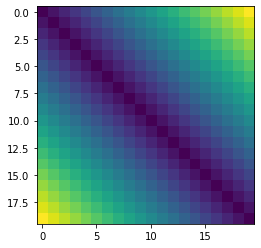

In [36]:
plt.imshow( y[0,0,:,:])

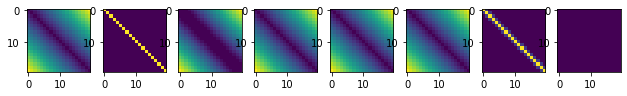

In [39]:
plt.figure(figsize=(12, 3))

for i in range(1,9):
  plt.subplot(1, 9, i)
  plt.imshow(model.threshold(y).detach().numpy()[0,i-1,:,:])